In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.nonparametric.kernel_regression import KernelReg
import seaborn as sns

In [40]:
def scatter_x_y(df, x_col, y_col, lowess_frac = 0.3, log_y = True, title: str = None):
    
    df = df.dropna(subset=[y_col, x_col])
    
    lowess = sm.nonparametric.lowess(df[y_col], df[x_col], frac=lowess_frac)
    X = df[x_col].values.reshape(-1, 1)
    ols_model = sm.OLS(df[y_col], sm.add_constant(X)).fit()
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    ax.scatter(df[x_col], df[y_col], c='blue', s=20, label='Data Points')
    ax.plot(X, ols_model.predict(sm.add_constant(X)), color='black', lw=2, label='OLS Fit')
    ax.plot(lowess[:, 0], lowess[:, 1], '--', color='black', lw=2, label='LOWESS')
    
    for _, row in df.iterrows():
        ax.text(row[x_col], row[y_col], fontsize=8, ha='right', va='bottom')
    
    ax.set_xlabel(f'{x_col}' )
    ax.set_ylabel(f"{y_col}")
    ax.set_title(title or f"Relationship: {y_col} vs {x_col}")
    ax.legend()
    
    return fig, ax

    


In [41]:
df = pd.read_csv('../Data for data description/DataAnalysisData.csv')

df['log_GDP'] =  np.log(df['GDP'])
for i in range(1,20):
    df[f'hhd_change_previous_{i}_quarter'] = df.groupby('Country')['household_debt'].diff(periods= -i)
    df[f'gdp_change_{i}_quarter'] = df.groupby('Country')['log_GDP'].diff(periods= i)

for i in range(1,4):
    df[f'hhd_change_previous_{i}_year'] = df.groupby('Country')['household_debt'].diff(periods= -i*4)
    df[f'gdp_change_{i}_year'] = df.groupby('Country')['log_GDP'].diff(periods= i*4)

# df['hhd_change_one_year'] = df.groupby('Country')['household_debt'].diff(periods= -4)
# df['hhd_change_two_year'] = df.groupby('Country')['household_debt'].diff(periods= -8)
# df['hhd_change_three_year'] = df.groupby('Country')['household_debt'].diff(periods= -12)
# df['gdp_change_one_year'] = df.groupby('Country')['log_GDP'].diff(periods=4)
# df['gdp_change_two_year'] = df.groupby('Country')['log_GDP'].diff(periods=8)
# df['gdp_change_three_year'] = df.groupby('Country')['log_GDP'].diff(periods=12)

df['hhd_change_3_year'] = df.groupby('Country')['household_debt'].diff(periods= 12)

df['hhd_second_deriv_previous_1_year'] = df.groupby('Country')['hhd_change_previous_1_year'].diff(periods= -4)
df['hhd_second_deriv_previous_2_year'] = df.groupby('Country')['hhd_change_previous_2_year'].diff(periods= -4)
df['hhd_second_deriv_previous_3_year'] = df.groupby('Country')['hhd_change_previous_3_year'].diff(periods= -4)
df['hhd_third_deriv_previous_1_year'] = df.groupby('Country')['hhd_second_deriv_previous_1_year'].diff(periods= -4)
df['hhd_third_deriv_previous_2_year'] = df.groupby('Country')['hhd_second_deriv_previous_2_year'].diff(periods= -4)
df['hhd_third_deriv_previous_3_year'] = df.groupby('Country')['hhd_second_deriv_previous_3_year'].diff(periods= -4)
df['gdp_second_deriv_1_year'] = df.groupby('Country')['gdp_change_1_year'].diff(periods=4)
df['gdp_second_deriv_2_year'] = df.groupby('Country')['gdp_change_2_year'].diff(periods=4)
df['gdp_second_deriv_3_year'] = df.groupby('Country')['gdp_change_3_year'].diff(periods=4)

# df['fe_hhd'] = df['hhd_change_1_year']- df.groupby('Country')['hhd_change_1_year'].transform('mean')
# df['fe_gdp'] = df['gdp_change_1_year'] - df.groupby('Country')['gdp_change_1_year'].transform('mean')

above80 = df[df['household_debt']>= 80]

usa = df[df['Country'] == 'Norway']
usa = usa[['TIME_PERIOD', 'log_GDP', 'gdp_change_1_year', 'household_debt', 'hhd_change_previous_3_year']]

/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_54474/4291998739.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_summary = df_copy.groupby(bin_var_name).agg(
/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_54474/4291998739.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_summary = df_copy.groupby(bin_var_name).agg(


3338


/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_54474/4291998739.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_summary = df_copy.groupby(bin_var_name).agg(


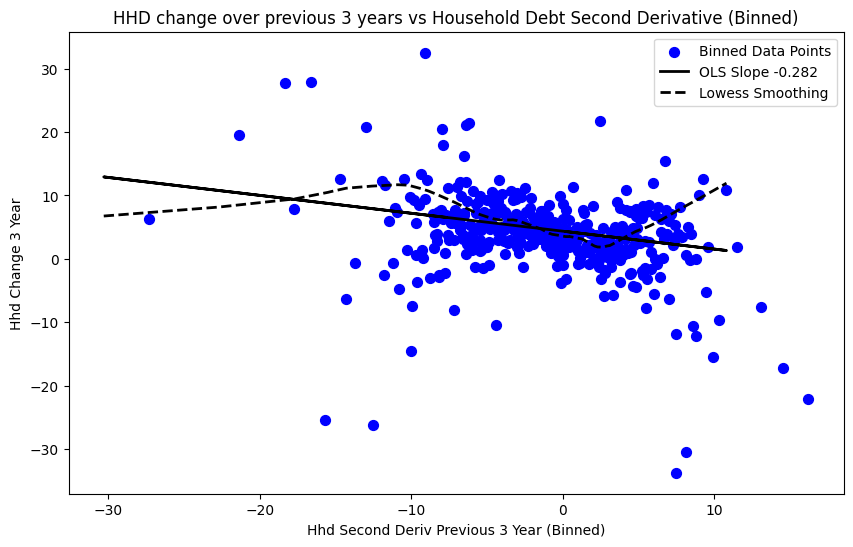

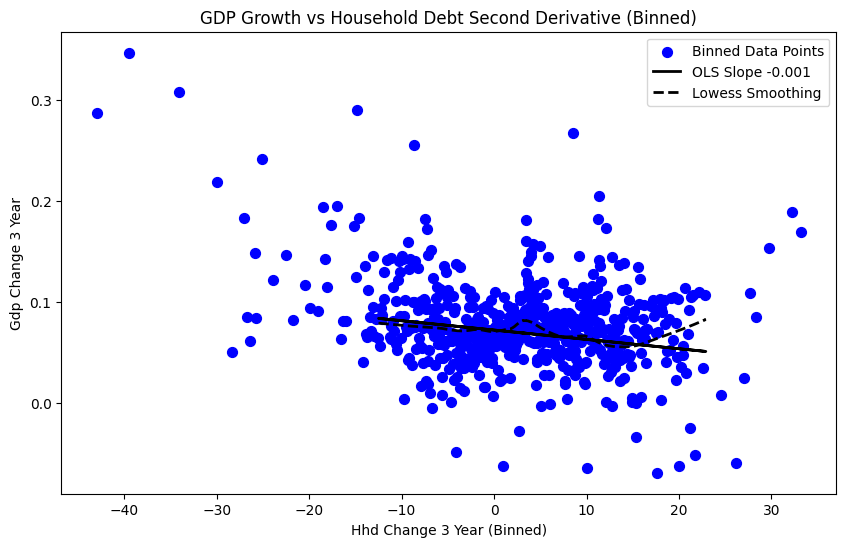

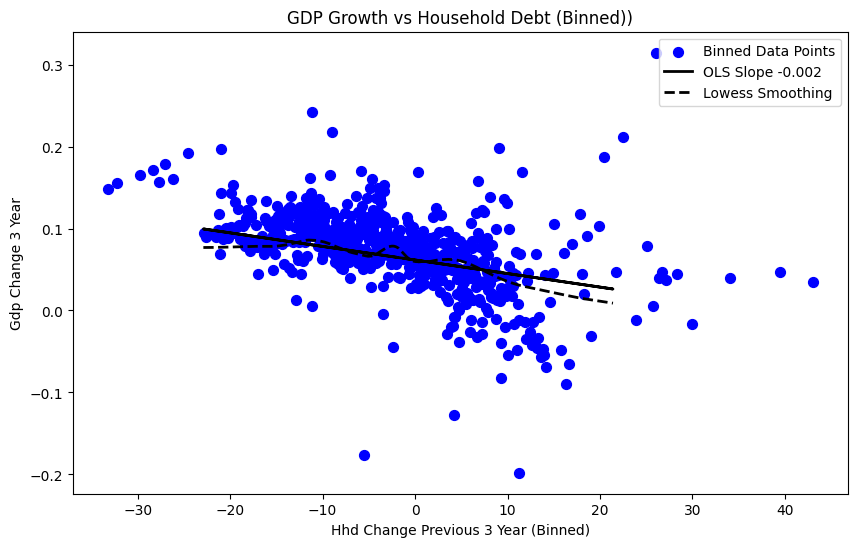

In [42]:
def plot_relationship_binned(df, x_var, y_var, num_buckets=50, 
                              lowess_fraction=0.3, figsize=(10, 6),
                              plot_title=None, scatter_color='blue',
                              scatter_size=50, line_width=2):
    
    bin_var_name = f"{x_var}_Bin"
    df_copy = df.copy()
    df_copy[bin_var_name] = pd.qcut(df_copy[x_var], num_buckets, duplicates='drop')
    
    bucket_summary = df_copy.groupby(bin_var_name).agg(
        {y_var: 'mean', x_var: 'mean'}
    ).reset_index()
    
    df_copy = df_copy.dropna()
    lowess_result = sm.nonparametric.lowess(
        df_copy[y_var], 
        df_copy[x_var], 
        frac=lowess_fraction
    )
    
    X = df_copy[x_var].values.reshape(-1, 1)
    y = df_copy[y_var]
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.scatter(
        bucket_summary[x_var], 
        bucket_summary[y_var],
        c=scatter_color, 
        label='Binned Data Points', 
        s=scatter_size, 
        marker='o'
    )

    ax.plot(
        X, 
        model.predict(sm.add_constant(X)), 
        color='black', 
        lw=line_width, 
        label=f'OLS Slope {model.params["x1"]:.3f}',
    )
    
    ax.plot(
        lowess_result[:, 0], 
        lowess_result[:, 1], 
        linestyle='--', 
        color='black', 
        label='Lowess Smoothing', 
        lw=line_width
    )
    
    x_label = x_var.replace('_', ' ').title()
    y_label = y_var.replace('_', ' ').title()
    
    ax.set_xlabel(f"{x_label} (Binned)")
    ax.set_ylabel(f"{y_label}")
    ax.legend()
    
    if plot_title:
        ax.set_title(plot_title)
    else:
        ax.set_title(f"{y_label} vs {x_label} (Binned)")

    

plot_relationship_binned(
    df=df,
    x_var='hhd_second_deriv_previous_3_year', 
    y_var='hhd_change_3_year',
    plot_title="HHD change over previous 3 years vs Household Debt Second Derivative (Binned)",
    num_buckets = 2000,
)

plot_relationship_binned(
    df=df,
    x_var='hhd_change_3_year', 
    y_var='gdp_change_3_year',
    plot_title="GDP Growth vs Household Debt Second Derivative (Binned)",
    num_buckets = 2000,
)


plot_relationship_binned(
    df=df,
    x_var='hhd_change_previous_3_year', 
    y_var='gdp_change_3_year',
    plot_title="GDP Growth vs Household Debt (Binned))",
    num_buckets = 2000,
)

print((df['hhd_change_3_year'] > 0).sum())

# scatter_x_y(df,  'hhd_second_deriv_three_year', 'gdp_change_three_year')



/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_54474/4291998739.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_summary = df_copy.groupby(bin_var_name).agg(


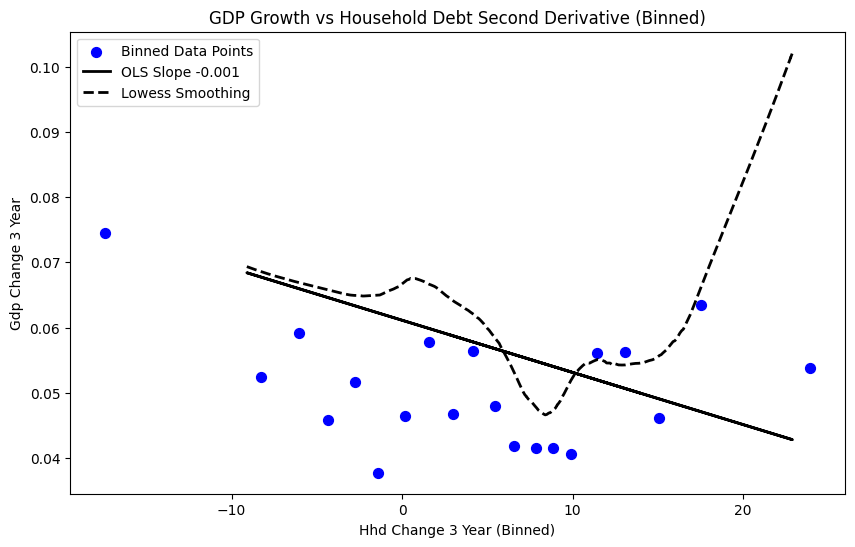

In [43]:
plot_relationship_binned(
    df=above80,
    x_var='hhd_change_3_year', 
    y_var='gdp_change_3_year',
    plot_title="GDP Growth vs Household Debt Second Derivative (Binned)",
    num_buckets = 20,
)


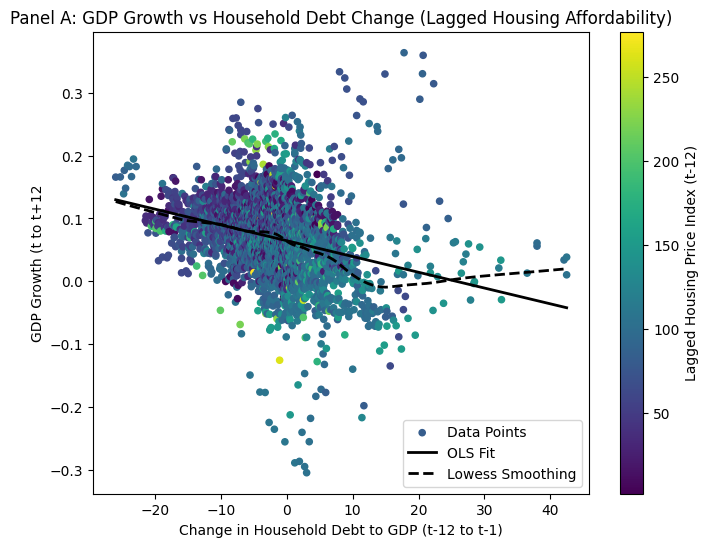

In [44]:

GDP_LAG = 12
HHD_LAG = 12
Price_LAG = HHD_LAG

df = df.reset_index()
df.sort_values(by=['Country', 'TIME_PERIOD'], inplace=True)

df['lnGDP'] = np.log(df['GDP'])
df['GDP_growth'] = df.groupby('Country')['lnGDP'].diff(periods= GDP_LAG )
df['household_debt_GDP_change'] = df.groupby('Country')['household_debt'].shift(-1) - df.groupby('Country')['household_debt'].shift(-HHD_LAG)

df = df.dropna(subset=['GDP_growth', 'household_debt_GDP_change'])
df[df['Country'] == 'United States']
df['housing_price_lagged'] = df.groupby('Country')['housing_price'].shift(Price_LAG)

df = df.dropna(subset=['housing_price_lagged'])

lowess_result = sm.nonparametric.lowess(df['GDP_growth'], df['household_debt_GDP_change'], frac=0.3)
df['GDP_growth_lowess'] = np.interp(df['household_debt_GDP_change'], lowess_result[:, 0], lowess_result[:, 1])

df = df.sort_values('household_debt_GDP_change')


fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(df['household_debt_GDP_change'], df['GDP_growth'], 
                     c=df['housing_price_lagged'], cmap='viridis', label='Data Points', s=20, marker='o')

X = df['household_debt_GDP_change'].values.reshape(-1, 1)
y = df['GDP_growth']
model = sm.OLS(y, sm.add_constant(X)).fit()


ax.plot(df['household_debt_GDP_change'], model.predict(sm.add_constant(df['household_debt_GDP_change'].values.reshape(-1, 1))), 
        color='black', lw=2, label='OLS Fit')

ax.plot(lowess_result[:, 0], lowess_result[:, 1], linestyle='--', color='black', label='Lowess Smoothing', lw=2)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(f'Lagged Housing Price Index (t-{Price_LAG})')

ax.set_xlabel(f"Change in Household Debt to GDP (t-{HHD_LAG} to t-1)")
ax.set_ylabel(f"GDP Growth (t to t+{GDP_LAG}")
ax.legend()
ax.set_title("Panel A: GDP Growth vs Household Debt Change (Lagged Housing Affordability)")

plt.show()